# Algorithmic Fairness, Accountability, and Ethics, Spring 2025

## Mandatory Assignment 2

Please use the following code to prepare the dataset.
 

In [152]:
from folktables.acs import adult_filter
from folktables import ACSDataSource
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from scipy import stats
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
import scipy.optimize as opt

In [153]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=False)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX']

target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: float = 35000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    df = df[df["SCHL"]>=15] 
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    race = df["RAC1P"]
    race = (df["RAC1P"] == 1).astype(int)
    race = race.values
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = [ "HINS1", "HINS2", "HINS4", "CIT", "COW", "SCHL", "MAR", "SEX", "RAC1P"]
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=cols, drop_first=True)
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True, columns=["ENG"], drop_first=True)
    return df_processed, df, target, sex, race

data, data_original, target, group_g, group_r = data_processing(acs_data, feature_names, target_name)


In [154]:
scaler = ColumnTransformer([("scaler",StandardScaler(), ["AGEP"])], remainder="passthrough")


features_transformed = pd.DataFrame(
    scaler.fit_transform(data), 
    columns=scaler.get_feature_names_out()
)
features_transformed.head()
features_transformed.rename(columns={"scaler__AGEP": "AGEP"}, inplace=True)

In [155]:
age_p = features_transformed["AGEP"]

data.drop("AGEP", axis = 1, inplace=True)

In [156]:
data = pd.concat([data.reset_index(drop=True), age_p.reset_index(drop=True)], axis=1)

In [180]:
group_r_df = pd.DataFrame(group_r)

group_r_df.rename(columns= {0:"race"}, inplace=True)


In [181]:
data = pd.concat([data.reset_index(drop=True), group_r_df.reset_index(drop=True)], axis=1)

In [182]:
data

,HINS1_2,HINS2_2,HINS4_2,CIT_2,CIT_3,CIT_4,CIT_5,COW_2.0,COW_3.0,COW_4.0,...,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9,ENG_2.0,ENG_3.0,ENG_4.0,ENG_nan,AGEP,race
0,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,-1.441110,1
1,1,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1.505785,1
2,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,-1.642035,1
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,-1.709010,0
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,-1.039261,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178278,0,1,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,-0.302537,0
178279,0,1,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,-0.235562,0
178280,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1.237885,1
178281,1,1,1,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,1.773684,0


In [183]:

X_train, X_test, y_train, y_test, group_g_train, group_g_test, group_r_train, group_r_test = train_test_split(
    data, target, group_g, group_r, test_size=0.2, random_state=0, shuffle=False)

## EDA to see the different distributions

In [37]:
print(target.shape)
print(data.shape)


(178283,)
(178283, 41)


In [197]:
target_d = pd.DataFrame(target)
print(target_d.shape)


(178283, 1)


In [198]:
for_analysis = pd.concat([data.reset_index(drop=True), target_d.reset_index(drop=True)], axis=1)

for_analysis.rename(columns={0:"target"}, inplace=True)

In [199]:
for_analysis.columns

Index(['HINS1_2', 'HINS2_2', 'HINS4_2', 'CIT_2', 'CIT_3', 'CIT_4', 'CIT_5',
       'COW_2.0', 'COW_3.0', 'COW_4.0', 'COW_5.0', 'COW_6.0', 'COW_7.0',
       'COW_8.0', 'SCHL_16.0', 'SCHL_17.0', 'SCHL_18.0', 'SCHL_19.0',
       'SCHL_20.0', 'SCHL_21.0', 'SCHL_22.0', 'SCHL_23.0', 'SCHL_24.0',
       'MAR_2', 'MAR_3', 'MAR_4', 'MAR_5', 'SEX_2', 'RAC1P_2', 'RAC1P_3',
       'RAC1P_4', 'RAC1P_5', 'RAC1P_6', 'RAC1P_7', 'RAC1P_8', 'RAC1P_9',
       'ENG_2.0', 'ENG_3.0', 'ENG_4.0', 'ENG_nan', 'AGEP', 'race', 'target'],
      dtype='object')

In [ ]:
print(np.unique(target, return_counts=True))


(array([False,  True]), array([ 74479, 103804]))


In [12]:
103804/178283

0.58224283863296

In [45]:
print(X_train.SEX_2.value_counts(normalize=True))
print(for_analysis.SEX_2.value_counts(normalize=True))

0    0.520775
1    0.479225
Name: SEX_2, dtype: float64
0    0.520123
1    0.479877
Name: SEX_2, dtype: float64


In [200]:
for_analysis.target.value_counts(normalize=True)

True     0.582243
False    0.417757
Name: target, dtype: float64

In [52]:
print(f"men's target : {for_analysis[for_analysis.SEX_2==0].target.value_counts(normalize=True)}")

print(f"women's target : {for_analysis[for_analysis.SEX_2==1].target.value_counts(normalize=True)}")

men's target : True     0.639185
False    0.360815
Name: target, dtype: float64
women's target : True     0.520525
False    0.479475
Name: target, dtype: float64


In [59]:
races = list(data_original.RAC1P.value_counts(normalize=True))


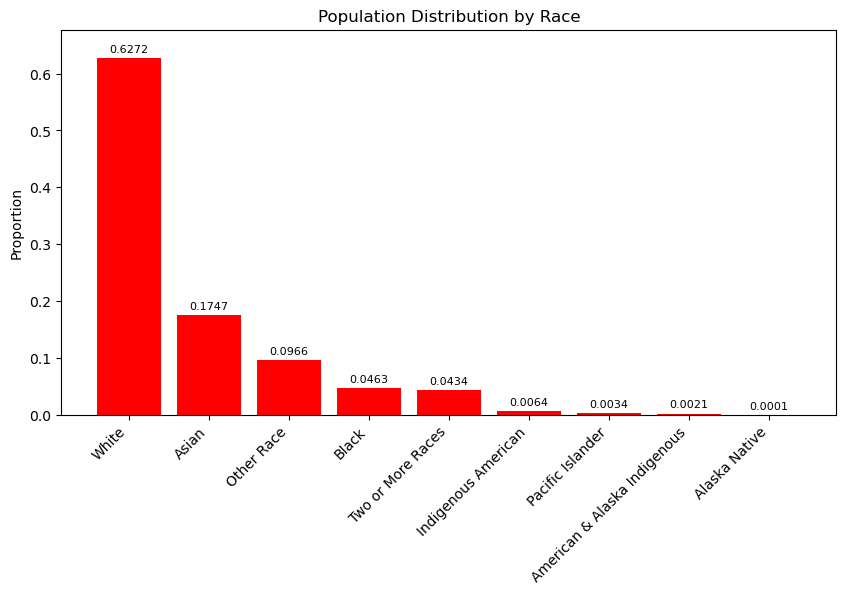

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Get population distribution
population_division = dict(data_original.RAC1P.value_counts(normalize=True))

# Mapping race codes to race names
race_mapping = {
    1: "White",
    2: "Black",
    3: "Indigenous American",
    4: "Alaska Native",
    5: "American & Alaska Indigenous",
    6: "Asian",
    7: "Pacific Islander",
    8: "Other Race",
    9: "Two or More Races"
}

# Extract race codes and population values
race_codes = list(population_division.keys())
population_values = list(population_division.values())

# Convert race codes to names
race_names = [race_mapping.get(code, f"Race {code}") for code in race_codes]

# Create the bar plot
plt.figure(figsize=(10, 5))
plt.bar(race_names, population_values, color="red")

# Labeling
plt.ylabel("Proportion")
plt.title("Population Distribution by Race")
plt.xticks(rotation=45, ha="right")

# Display values on bars
for i, value in enumerate(population_values):
    plt.text(i, value + 0.01, f"{value:.4f}", ha='center', fontsize=8)

plt.ylim(0, max(population_values) + 0.05)
plt.show()


 "RAC1P": {
        1.0: "White alone",
        2.0: "Black or African American alone",
        3.0: "American Indian alone",
        4.0: "Alaska Native alone",
        5.0: (
            "American Indian and Alaska Native tribes specified;"
            "or American Indian or Alaska Native,"
            "not specified and no other"
        ),
        6.0: "Asian alone",
        7.0: "Native Hawaiian and Other Pacific Islander alone",
        8.0: "Some Other Race alone",
        9.0: "Two or More Races",
    }

In [68]:
print(f"white people's target : {data_original[data_original.RAC1P==1].target.value_counts(normalize=True)}")

print(f"non-white people's target : {data_original[data_original.RAC1P!=1].target.value_counts(normalize=True)}")

white people's target : True     0.609297
False    0.390703
Name: target, dtype: float64
non-white people's target : True     0.536727
False    0.463273
Name: target, dtype: float64


In [69]:
# Identify white people (where all RAC1P_2 to RAC1P_9 columns are 0)
white_mask = (for_analysis.loc[:, "RAC1P_2":"RAC1P_9"] == 0).all(axis=1)

# Identify non-white people (where at least one RAC1P_2 to RAC1P_9 column is 1)
non_white_mask = (for_analysis.loc[:, "RAC1P_2":"RAC1P_9"] == 1).any(axis=1)

# Get target distribution for white people
white_target_distribution = for_analysis.loc[white_mask, "target"].value_counts(normalize=True)

# Get target distribution for non-white people
non_white_target_distribution = for_analysis.loc[non_white_mask, "target"].value_counts(normalize=True)

# Print results
print(f"White people's target distribution:\n{white_target_distribution}\n")
print(f"Non-white people's target distribution:\n{non_white_target_distribution}\n")


White people's target distribution:
True     0.609297
False    0.390703
Name: target, dtype: float64

Non-white people's target distribution:
True     0.536727
False    0.463273
Name: target, dtype: float64



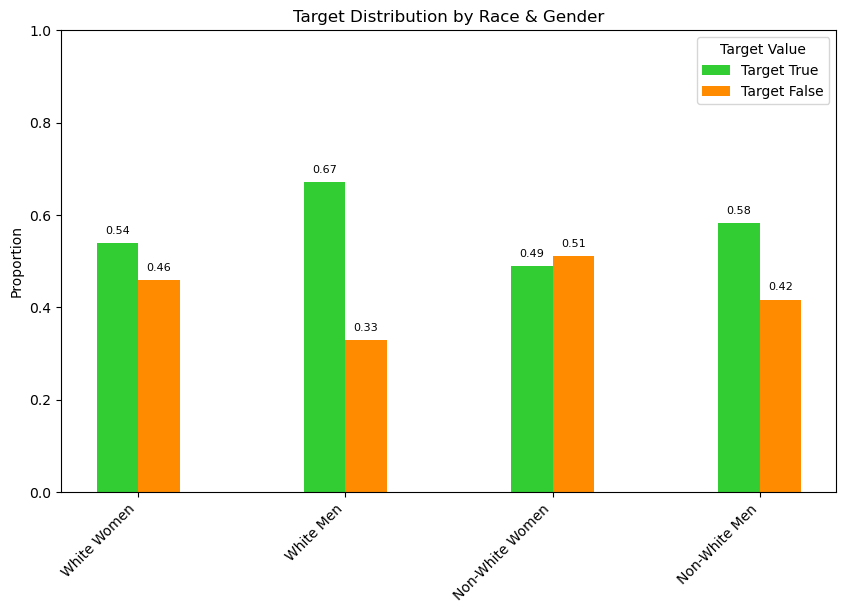

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Define masks for race
white_mask = (for_analysis.loc[:, "RAC1P_2":"RAC1P_9"] == 0).all(axis=1)
non_white_mask = (for_analysis.loc[:, "RAC1P_2":"RAC1P_9"] == 1).any(axis=1)

# Define masks for gender
woman_mask = for_analysis["SEX_2"] == 1
man_mask = for_analysis["SEX_2"] == 0

# Create combined groups
groups = {
    "White Women": for_analysis[white_mask & woman_mask],
    "White Men": for_analysis[white_mask & man_mask],
    "Non-White Women": for_analysis[non_white_mask & woman_mask],
    "Non-White Men": for_analysis[non_white_mask & man_mask]
}

# Collect data for plotting
group_names = []
target_distributions = []
for group_name, group_df in groups.items():
    target_dist = group_df["target"].value_counts(normalize=True).sort_index()
    group_names.append(group_name)
    target_distributions.append(target_dist)

target_colors = {True: "limegreen", False: "darkorange"}

# Convert list to numpy array for plotting
target_categories = sorted(for_analysis["target"].unique(), reverse=True)  # Reversed order
  # Ensure correct order of target values
num_targets = len(target_categories)
num_groups = len(groups)
bar_width = 0.2  # Width of bars

# Create bar positions
x = np.arange(num_groups)

# Plot results
plt.figure(figsize=(10, 6))

for i, target_val in enumerate(target_categories):
    values = [dist.get(target_val, 0) for dist in target_distributions]  # Get proportions for each group
    plt.bar(x + i * bar_width, values, bar_width, label=f"Target {target_val}", color=target_colors[target_val])

# Labeling
plt.xticks(x + (num_targets - 1) * bar_width / 2, group_names, rotation=45, ha="right")
plt.ylabel("Proportion")
plt.title("Target Distribution by Race & Gender")
plt.legend(title="Target Value")
plt.ylim(0, 1)

# Display values on bars
for i, target_val in enumerate(target_categories):
    values = [dist.get(target_val, 0) for dist in target_distributions]
    for j, value in enumerate(values):
        plt.text(x[j] + i * bar_width, value + 0.02, f"{value:.2f}", ha="center", fontsize=8)

plt.show()


# Task 1

Train one logistic regression model without any fairness constraing on the Folktales dataset and calculate its general accuracy, and respectively the accuracies for men and women (feature SEX) and for different races (feature RAC1P). Remember to evaluate the model using cross validation.

In [32]:
kf = KFold(n_splits=5)


logistic_model = LogisticRegression(max_iter=5000, penalty="l2", C=0.8497534359086438, tol=1e-4, solver="saga")
logistic_model.fit(X_train, y_train)


LogisticRegression(C=0.8497534359086438, max_iter=5000, solver='saga')

In [60]:
type(y_test)

numpy.ndarray

In [61]:
log_y_pred = logistic_model.predict(X_test)
accuracy = accuracy_score(y_test, log_y_pred)
accuracy
f1_score = f1_score(y_test, log_y_pred) 
balanced_accuracy = balanced_accuracy_score(y_test, log_y_pred)

In [34]:
print(accuracy)
print(f1_score)
print(balanced_accuracy)

0.769682876344773
0.7972921305355014
0.7638337740407731


In [ ]:

# evaluate model
scores = cross_val_score(
    logistic_model, X_train, y_train, scoring='accuracy', cv=kf, n_jobs=-1)

print('Accuracy: %.3f ,\nStandard Deviations :%.3f' %
      (mean(scores), std(scores)))

KeyboardInterrupt: 

In [ ]:
type(y_true_gender_women)

numpy.ndarray

In [35]:

# Step 2: Filter data for a specific gender (sex_2 == 1)
gender_mask_women = (X_test['SEX_2'] == 1)  # Change to 0 for the other gender # Women
y_true_gender_women = y_test[gender_mask_women]
y_pred_gender_women = log_y_pred[gender_mask_women]
# Step 3: Compute accuracy for the selected gender
accuracy_women = accuracy_score(y_true_gender_women, y_pred_gender_women)
#f1_score_women = f1_score(y_true_gender_women, y_pred_gender_women) 
balanced_accuracy_women = balanced_accuracy_score(y_true_gender_women, y_pred_gender_women)

print(f"Accuracy for gender sex_2 = 1 --> Women: {accuracy_women:.4f}, and balanced accuracy: {balanced_accuracy_women}")

# Step 2: Filter data for a specific gender (sex_2 == 1)
gender_mask_men = (X_test['SEX_2'] == 0)  # Change to 0 for the other gender # Women
y_true_gender_men = y_test[gender_mask_men]
y_pred_gender_men = log_y_pred[gender_mask_men]

# Step 3: Compute accuracy for the selected gender
accuracy_men = accuracy_score(y_true_gender_men, y_pred_gender_men)
#f1_score_men = f1_score(y_true_gender_men, y_pred_gender_men) 
balanced_accuracy_men = balanced_accuracy_score(y_true_gender_men, y_pred_gender_men)

print(f"Accuracy for gender sex_2 = 0 --> Men: {accuracy_men:.4f}, and balanced accuracy: {balanced_accuracy_men}")


Accuracy for gender sex_2 = 1 --> Women: 0.7508, and balanced accuracy: 0.7512019904525913
Accuracy for gender sex_2 = 0 --> Men: 0.7866, and balanced accuracy: 0.7683725749312639


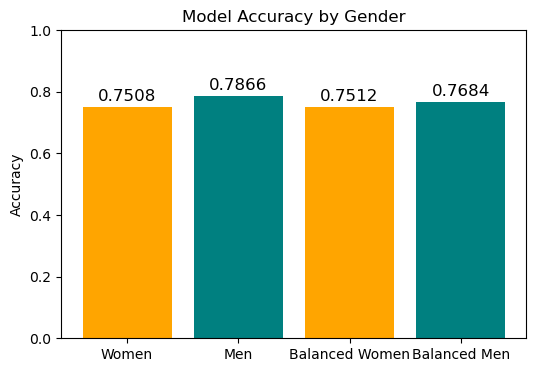

In [ ]:


# Accuracy values
genders = ["Women", "Men", "Balanced Women", "Balanced Men"]
accuracies = [accuracy_women, accuracy_men, balanced_accuracy_women, balanced_accuracy_men]

# Plot the accuracies
plt.figure(figsize=(6, 4))
plt.bar(genders, accuracies, color=['orange', 'teal'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy by Gender")
plt.xticks(rotation=0)

# Display values on bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha='center', fontsize=12)

plt.show()


In [37]:
f1_scores = [f1_score_women, f1_score_men]

# Plot the accuracies
plt.figure(figsize=(6, 4))
plt.bar(genders, f1_scores, color=['orange', 'teal'])
plt.ylim(0, 1)
plt.ylabel("F1 Score")
plt.title("Model F1 Score by Gender")
plt.xticks(rotation=0)

# Display values on bars
for i, acc in enumerate(f1_scores):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha='center', fontsize=12)

plt.show()

NameError: name 'f1_score_women' is not defined

In [41]:
# Step 2: Identify race columns
race_columns = [col for col in X_test.columns if col.startswith("RAC1P_")]

race_accuracies = {}
race_balanced_accuracies = {}
# calculate accuracy for each race group, plus all them being 0 = white
race1_mask = (X_test[race_columns].sum(axis=1) == 0)  # Rows where all race columns are 0
if race1_mask.sum() > 0:  # Check if there are any such samples
    y_true_other = y_test[race1_mask]
    y_pred_other = log_y_pred[race1_mask]
    accuracy_other = accuracy_score(y_true_other, y_pred_other)
    #f1_score_other = f1_score(y_true_other, y_pred_other) 
    balanced_accuracy_other = balanced_accuracy_score(y_true_other, y_pred_other)
    race_accuracies["RAC1P_1"] = accuracy_other
    race_balanced_accuracies["RAC1P_1"] = balanced_accuracy_other

for race_col in race_columns:
    race_mask = (X_test[race_col] == 1)  # Select people belonging to this race
    if race_mask.sum() > 0:  # Avoid division by zero
        y_true_race = y_test[race_mask]
        y_pred_race = log_y_pred[race_mask]
        accuracy = accuracy_score(y_true_race, y_pred_race)
        #f1_score_other = f1_score(y_true_race, y_pred_race) 
        balanced_accuracy_other = balanced_accuracy_score(y_true_race, y_pred_race)
        race_accuracies[race_col] = accuracy
        race_balanced_accuracies[race_col] = balanced_accuracy_other




for race, acc in race_accuracies.items():
    print(f"Accuracy for {race}: {acc:.4f}")

for race, acc in race_balanced_accuracies.items():
    print(f"Balance Accuracy for {race}: {acc:.4f}")


Accuracy for RAC1P_1: 0.7744
Accuracy for RAC1P_2: 0.7303
Accuracy for RAC1P_3: 0.7760
Accuracy for RAC1P_4: 0.4000
Accuracy for RAC1P_5: 0.8111
Accuracy for RAC1P_6: 0.7766
Accuracy for RAC1P_7: 0.6637
Accuracy for RAC1P_8: 0.7522
Accuracy for RAC1P_9: 0.7663
Balance Accuracy for RAC1P_1: 0.7605
Balance Accuracy for RAC1P_2: 0.7294
Balance Accuracy for RAC1P_3: 0.7645
Balance Accuracy for RAC1P_4: 0.2500
Balance Accuracy for RAC1P_5: 0.7644
Balance Accuracy for RAC1P_6: 0.7501
Balance Accuracy for RAC1P_7: 0.6723
Balance Accuracy for RAC1P_8: 0.7129
Balance Accuracy for RAC1P_9: 0.7658


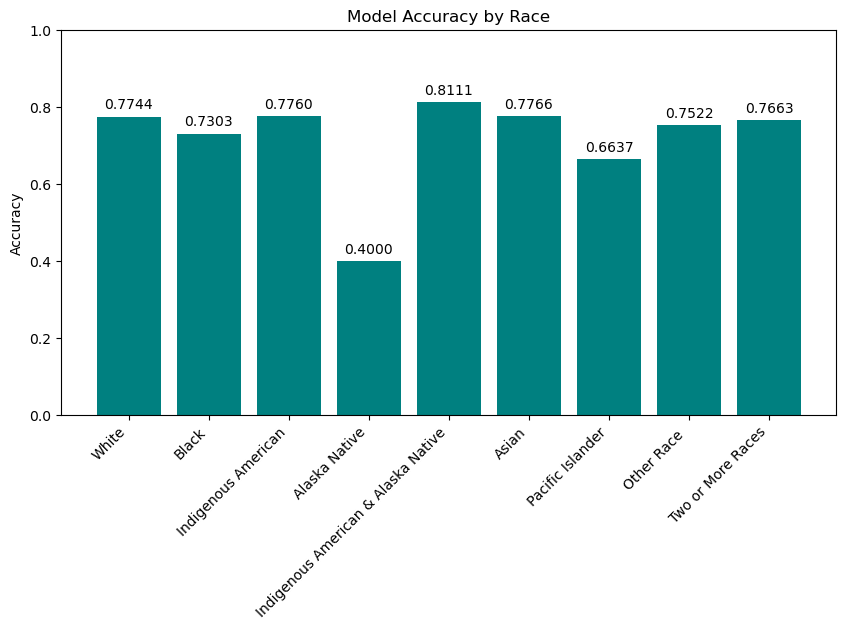

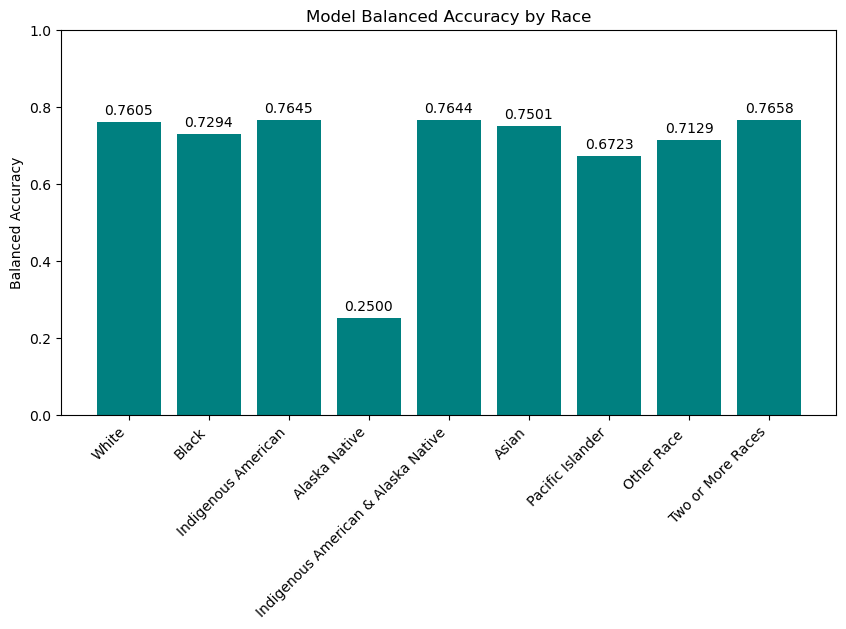

In [43]:
import matplotlib.pyplot as plt

# Mapping from RAC1P_# to race names
race_mapping = {
    1: "White",
    2: "Black",
    3: "Indigenous American",
    4: "Alaska Native",
    5: "Indigenous American & Alaska Native",
    6: "Asian",
    7: "Pacific Islander",
    8: "Other Race ",
    9: "Two or More Races"
}

# Extract numeric values from column names (RAC1P_# → #)
race_codes = [int(col.split('_')[1]) for col in race_accuracies.keys()]

# Map numeric values to race names
race_names = [race_mapping.get(code, f"Race {code}") for code in race_codes]
race_accuracies_values = list(race_accuracies.values())
race_balanced_accuracies_values = list(race_balanced_accuracies.values())

# Plot the race-based accuracy results
plt.figure(figsize=(10, 5))
plt.bar(race_names, race_accuracies_values, color='teal')
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy by Race")

# Adjust x-axis labels
plt.xticks(rotation=45, ha="right")

# Display values on bars
for i, acc in enumerate(race_accuracies_values):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha='center', fontsize=10)

plt.show()

# Plot the race-based accuracy results
plt.figure(figsize=(10, 5))
plt.bar(race_names, race_balanced_accuracies_values, color='teal')
plt.ylim(0, 1)
plt.ylabel("Balanced Accuracy")
plt.title("Model Balanced Accuracy by Race")
plt.xticks(rotation=45, ha="right")

# Display values on bars
for i, acc in enumerate(race_balanced_accuracies_values):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha='center', fontsize=10)

plt.show()


In [52]:
population_division = dict(data_original.RAC1P.value_counts(normalize=True))
pop_sorted = dict(sorted(population_division.items()))
pop_sorted

{1: 0.6184345692893466,
 2: 0.043732910842511435,
 3: 0.006613344236322286,
 4: 6.644008892750365e-05,
 5: 0.0022998492321058953,
 6: 0.1671683745176705,
 7: 0.0032555643574476785,
 8: 0.11648991899419926,
 9: 0.04193902844146884}

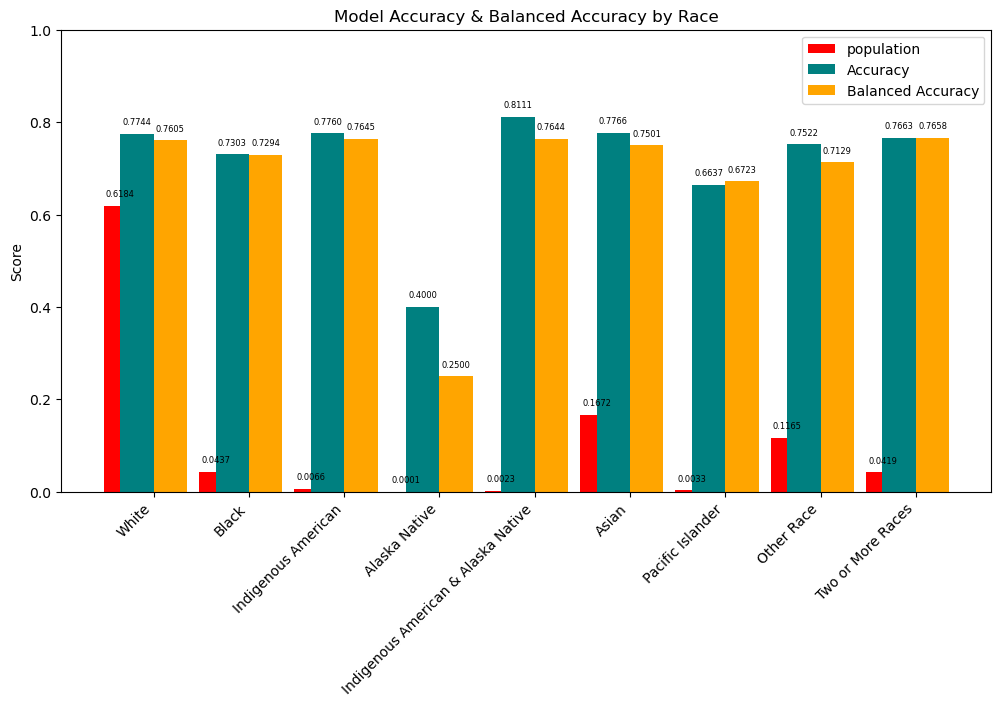

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Mapping from RAC1P_# to race names
race_mapping = {
    1: "White",
    2: "Black",
    3: "Indigenous American",
    4: "Alaska Native",
    5: "Indigenous American & Alaska Native",
    6: "Asian",
    7: "Pacific Islander",
    8: "Other Race",
    9: "Two or More Races"
}

# Extract numeric values from column names (RAC1P_# → #)
race_codes = [int(col.split('_')[1]) for col in race_accuracies.keys()]

# Map numeric values to race names
race_names = [race_mapping.get(code, f"Race {code}") for code in race_codes]
race_accuracies_values = list(race_accuracies.values())
race_balanced_accuracies_values = list(race_balanced_accuracies.values())
population_values = list(pop_sorted.values())
# Set positions for bars
x = np.arange(len(race_names))  # The label locations
width = 0.35  # Width of the bars

# Create the bar plot
plt.figure(figsize=(12, 6))
bars0 = plt.bar(x- width, population_values, width, label= "population", color="red")
bars1 = plt.bar(x - width/2, race_accuracies_values, width, label="Accuracy", color='teal')
bars2 = plt.bar(x + width/2, race_balanced_accuracies_values, width, label="Balanced Accuracy", color='orange')

# Labeling
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Model Accuracy & Balanced Accuracy by Race")
plt.xticks(x, race_names, rotation=45, ha="right")
plt.legend()

# Display values on bars
for bar in bars0:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f"{bar.get_height():.4f}", ha='center', fontsize=6)
for bar in bars1:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f"{bar.get_height():.4f}", ha='center', fontsize=6)
for bar in bars2:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f"{bar.get_height():.4f}", ha='center', fontsize=6)

plt.show()


# Task 2

- Use the group fairness constrain from Berk et al. (see lecture 6) to ensure
a fair model is trained. Here you have to train two ‘fair’-logistic regression
models. models (see more below). 

Subtasks:
-  Build one logistic regression model with where SEX splits the data
into two groups. Calculate: a) the model’s overall accuracy, b)
separate accuracies for each of the different values of SEX. Plot the
results and discuss what they mean. Is the model fair(er)?
-  Build one logistic regression model with where RAC1P splits the data
into two groups. Calculate: a) the model’s overall accuracy, b)
separate accuracies for each of the different values of RAC1P. Plot

In [ ]:
import numpy as np

def group_fairness_loss(beta, X, y, groups):
    """
    Computes the group fairness loss as defined by Berk et al. (2017).
    
    Args:
        beta: Model coefficients (numpy array).
        X: Feature matrix (numpy array).
        y: Target labels (numpy array).
        groups: Group membership labels (numpy array, e.g., 1 for S1, 2 for S2).
        
    Returns:
        Group fairness loss value.
    """
    # Identify group members
    group_1_mask = (groups == 1)
    group_2_mask = (groups == 2)

    # Extract relevant samples
    X1, y1 = X[group_1_mask], y[group_1_mask]
    X2, y2 = X[group_2_mask], y[group_2_mask]

    n1, n2 = len(y1), len(y2)
    
    if n1 == 0 or n2 == 0:
        return 0  # Avoid division by zero if a group is missing

    # Compute predictions
    preds_1 = X1.dot(beta)
    preds_2 = X2.dot(beta)

    # Compute fairness loss
    fairness_loss = 0
    for i in range(n1):
        for j in range(n2):
            d_y = abs(y1[i] - y2[j])  # Label distance function
            pred_diff = preds_1[i] - preds_2[j]  # Prediction difference
            fairness_loss += d_y * (pred_diff ** 2)  # Apply the fairness penalty

    return fairness_loss / (n1 * n2)  # Normalize by cross-group pairs


1️⃣ Train a normal logistic regression model using LogisticRegression().
2️⃣ Compute the fairness loss by checking how different the model treats two groups.
3️⃣ Modify the loss function to include both fairness and L2 regularization.
4️⃣ Train the fair model using train_fair_logistic_regression().
5️⃣ Use the new model (fair_beta) for predictions instead of the standard model.

In [89]:
from scipy.special import expit  # Sigmoid function
from scipy.optimize import fmin_tnc

def group_fairness_loss(beta, X, y, groups):
    """
    Computes group fairness loss as per Berk et al. (2017).
    Penalizes prediction differences across groups.
    """
    group_1_mask = (groups == 1)  # Males
    group_2_mask = (groups == 2)  # Females

    X1, y1 = X[group_1_mask], y[group_1_mask]
    X2, y2 = X[group_2_mask], y[group_2_mask]

    n1, n2 = len(y1), len(y2)
    if n1 == 0 or n2 == 0:
        return 0  # Avoid division by zero

    preds_1 = X1.dot(beta)
    preds_2 = X2.dot(beta)

    fairness_loss = 0
    for i in range(n1):
        for j in range(n2):
            d_y = abs(int(y1[i]) - int(y2[j]))  
            pred_diff = preds_1.iloc[i] - preds_2.iloc[j]
            fairness_loss += d_y * (pred_diff ** 2)

    return fairness_loss / (n1 * n2)

def logistic_loss(y_true, y_pred_probs, eps=1e-10):
    """Computes logistic loss (cross-entropy)."""
    return -np.mean(y_true * np.log(y_pred_probs + eps) + (1 - y_true) * np.log(1 - y_pred_probs + eps))

def l2_loss(beta):
    """L2 regularization loss."""
    return np.sum(beta[1:] ** 2)  # Exclude bias term

def compute_gradient(beta,X,y, groups, _lambda,_gamma):
    """Calculate the gradient - used for finding the best beta values. 
       You do not need to use groups and lambda (fmin_tnc expects same input as in func, that's why they are included here)"""
    grad = np.zeros(beta.shape)
    NotImplemented

    for i in range(len(grad)):
        if i == 0: # we do not want to regularize the intercept
            grad[i] =  ...
        else:
            grad[i] = ...
        
    return grad

def compute_cost(beta, X, y, groups, _lambda, _gamma):
    """Total cost function: logistic loss + fairness penalty + L2 regularization."""
    probs = expit(X.dot(beta))  # Sigmoid function
    loss = logistic_loss(y, probs)
    fair_loss = _lambda * group_fairness_loss(beta, X, y, groups)
    reg_loss = _gamma * l2_loss(beta)
    return loss + fair_loss + reg_loss  

def compute_cost2(beta, X, y, groups, _lambda, _gamma):
    loss = logistic_loss(y, expit(X.dot(beta)))
    grad = compute_gradient(beta, X, y, groups, _lambda, _gamma)  # Ensure this is correctly defined
    return loss, grad  # Must return a tuple


def train_fair_logistic_regression(X, y, groups, _lambda=1.0, _gamma=0.1):
    """Trains a logistic regression model with fairness constraints."""
    beta_init = np.zeros(X.shape[1])

    beta_opt, _, _ = fmin_tnc(
        func=compute_cost,
        x0=beta_init,
        args=(X, y, groups, _lambda, _gamma),
        disp=5
    )
    return beta_opt


In [79]:
X_train_small.shape

(3000, 55)

In [25]:
N = 3000 ### I am subsampling because it is slow on my machine
X_train_small = X_train[:N]
y_train_small = y_train[:N]
group_train_small = group_train[:N]
group_test_small = group_test[:N]
X_test_small = X_test[:N]
y_test_small = y_test[:N]


In [91]:

# Train the fairness-aware logistic regression model using the correct inputs
fair_beta = train_fair_logistic_regression(X_train_small, y_train_small, group_train_small, _lambda=1.0, _gamma=0.1)

# Make predictions with the fair model
fair_probs = expit(X_test_small.values.dot(fair_beta))
fair_preds = (fair_probs >= 0.5).astype(int)

# Compute accuracy for the fair model
fair_accuracy = accuracy_score(y_test_small, fair_preds)
print(f"Fair Model Accuracy: {fair_accuracy:.4f}")

# Compute accuracy separately for different values of SEX
accuracy_male = accuracy_score(y_test_small[group_test_small == 1], fair_preds[group_test_small == 1])
accuracy_female = accuracy_score(y_test_small[group_test_small == 2], fair_preds[group_test_small == 2])

print(f"Fair Model Accuracy for Males: {accuracy_male:.4f}")
print(f"Fair Model Accuracy for Females: {accuracy_female:.4f}")



IndexError: invalid index to scalar variable.

plot


In [ ]:
# Accuracy comparison
accuracies = [overall_accuracy, accuracy_male, accuracy_female, fair_accuracy]
labels = ["Overall", "Male", "Female", "Fair Model"]

plt.figure(figsize=(8, 5))
plt.bar(labels, accuracies, color=['blue', 'green', 'orange', 'red'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Before and After Fairness Adjustment")

# Show values on bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha='center', fontsize=10)

plt.show()


# sampling the dataset with division of gender and race

In [ ]:
# subsamplke of data

In [ ]:
X_train, X_test, y_train, y_test, group_g_train, group_g_test, group_r_train, group_r_test = train_test_split(
    data, target, group_g, group_r, test_size=0.2, random_state=0, shuffle=False)

# task 2- gender division


In [158]:
def sigmoid(x):
    """
    Compute the sigmoid function 
    f = 1/(1+exp(-beta^T * x))
    This function assumes as input that you have already multiplied beta and X together
    """
    return 1./(1 + np.exp(-x))

def logistic_loss(y_true, y_pred, eps = 1e-9):
    """
    Loss for the logistic regression, y_pred are probabilities
    """
    return -np.mean(y_true * np.log(y_pred + eps) + (1-y_true) * np.log(1-y_pred + eps))

def l2_loss(beta):
    """
    L2-Regularisation
    """
    return np.linalg.norm(beta,2)

def fair_loss_group(y, probs, groups, group_type):
    """
    Individual fairness Loss for gender
    """
    if group_type == "gender":
        n = y.shape[0]
        n1 = np.sum(groups == 1)
        n2 = np.sum(groups == 2)
    elif group_type == "race":
        n = y.shape[0]
        n1 = np.sum(groups == 0)
        n2 = np.sum(groups == 1)
    #print(n, n1, n2)
    
    ## Solution with numpy
    equal_pairs = np.argwhere(y[np.newaxis, :] == y[:, np.newaxis]) ### Check if labels are the same, distance is 1 if y[i] == y[j] and 0 if y[i] != y[j]
    equal_pairs = equal_pairs[np.where(equal_pairs[:,0] != equal_pairs[:,1])] ### Remove the pairs where items are compared to themselves
    
    
    diff_groups = (groups[equal_pairs[:,0]] != groups[equal_pairs[:,1]]).astype(int) ### Find pairs where groups are different
    
    diff_probs = probs[equal_pairs[:,0]].to_numpy() - probs[equal_pairs[:,1]].to_numpy()
   
    
    cost = diff_groups.dot(diff_probs)  # Ensures correct dot product shape
    cost /= (n1*n2)
    
    return cost**2

def compute_cost(beta, X, y, groups, group_type, _lambda, _gamma):
    # Compute predicted probs
    probs = sigmoid(X.dot(beta).astype(float))
    # Compute joint loss
    loss = logistic_loss(y, probs) + _lambda * fair_loss_group(y, probs, groups, group_type) + _gamma * l2_loss(beta[1:])
    return loss

def compute_gradients(beta, X, y, groups, group_type, _lambda, _gamma):
    """
    Calculate the gradient - used for finding the best beta values
    """
    # Start with empty gradient
    grad = np.zeros(beta.shape)
    
    m = len(X) # Number of training samples
    
    # Calculate the probs
    probs = sigmoid(X.dot(beta).astype(float))
    
    # Calculate gradients for each beta value
    for j in range(len(grad)):
        if j == 0: ### We do not want to regularize the intercept
            grad[j] = (1/m) * (probs-y).dot(X.iloc[:,j])
        else:
            grad[j] = (1/m) * (probs-y).dot(X.iloc[:,j]) + (2*_gamma)*beta[j]
        
    return grad

In [184]:
N = 10000 ### I am subsampling because it is slow on my machine
X_train_small = X_train[:N]
y_train_small = y_train[:N]
group_g_train_small = group_g_train[:N]
group_g_test_small = group_g_test[:N]
group_r_train_small = group_r_train[:N]
group_r_test_small = group_r_train[:N]
X_test_small = X_test[:N]
y_test_small = y_test[:N]

In [189]:
print(X_train_small.SEX_2.value_counts(normalize=True))
print(X_train_small.race.value_counts(normalize=True))

0    0.552
1    0.448
Name: SEX_2, dtype: float64
1    0.6031
0    0.3969
Name: race, dtype: float64


In [94]:
# Compute cost with random beta-values and parameters
np.random.seed(42)
compute_cost(
    beta = np.random.rand(X_train_small.shape[1]),
    X = X_train_small, 
    y = y_train_small,
    groups = group_g_train_small, 
    group_type = "gender",
    _gamma = 1, 
    _lambda = 0.1
)

5.401961818984595

In [95]:
# Set seed and define params
np.random.seed(23)
beta = np.random.rand(X_train_small.shape[1])
lambda_ = 0.1
gamma_ = 1e-5 

# Run optimization
result_g, _, _ = opt.fmin_tnc(
    func=compute_cost,
    x0=beta,
    fprime=compute_gradients,
    approx_grad=False,
    maxfun = 500,
    args = (
        X_train_small, 
        y_train_small,
        group_g_train_small,
        "gender",
        lambda_, 
        gamma_
    ),
    xtol=1e-7,
    ftol=1e-5
)

  NIT   NF   F                       GTG
    0    1  1.915777665845811E+00   1.31349986E+00
    1    6  6.492695811805719E-01   1.86866633E-01
    2    9  4.481697210743187E-01   2.07726994E-03
    3   15  4.251450019410666E-01   1.43482772E-04
tnc: fscale = 56.4887
    4   24  4.199559719172797E-01   2.20589081E-05
    5   32  4.183605526436989E-01   1.66689302E-06
    6   35  4.182444107173471E-01   3.90257196E-06
    7   40  4.181750589813221E-01   8.34182363E-08
tnc: fscale = 2094.73
tnc: |fn-fn-1] = 1.88574e-06 -> convergence
    8   44  4.181731732378561E-01   2.57291445E-08
tnc: Converged (|f_n-f_(n-1)| ~= 0)


In [96]:


# Save result
np.save("optimized_beta_g_10000.npy", result_g)


In [162]:

# Load result next time
result_g = np.load("optimized_beta_g.npy")
result_g

array([-1.12167814, -0.04890139,  0.76776263, -0.67215549,  0.32494875,
        0.08117417, -0.1859862 , -0.20971266, -0.0348106 , -0.17364523,
        0.06358754, -0.49810653,  0.15041303, -0.96868157,  0.07555109,
        0.14478057,  0.11382516,  0.23134114,  0.68608629,  1.42721464,
        1.8037429 ,  2.13351972,  2.22194786, -0.37045301, -0.08107954,
       -0.74377284, -0.95879845, -0.69107671, -0.28607984,  0.19165901,
        0.64392543, -1.10941553, -0.08167505, -0.14017955, -0.04035706,
       -0.25903056, -0.27646314, -0.83380146, -1.21652339,  0.07799365,
        0.67377322])

In [163]:
from sklearn.metrics import accuracy_score

y_pred_fair_g = np.array([True if x >=0.5 else False for x in sigmoid(result_g @ X_test_small.T)])

accuracy_score(y_test_small, y_pred_fair_g)

0.7515

In [164]:

logistic_model = LogisticRegression(max_iter=5000, penalty="l2", C=0.8497534359086438, tol=1e-4, solver="saga")
logistic_model.fit(X_train_small, y_train_small)
log_y_pred = logistic_model.predict(X_test_small)
accuracy = accuracy_score(y_test_small, log_y_pred)
accuracy
#f1_score = f1_score(y_test_small, log_y_pred) 
balanced_accuracy = balanced_accuracy_score(y_test_small, log_y_pred)

In [166]:
accuracy
balanced_accuracy

0.7324511504512965

In [ ]:
print('Fair')
print(f'Group 1: {accuracy_score(y_test_small[group_g_test_small==1], y_pred_fair_g[group_g_test_small==1]):.3f}\nGroup 2: {accuracy_score(y_test_small[group_g_test_small==2], y_pred_fair_g[group_g_test_small==2]):.3f}\n')
print('Basic')
print(f'Group 1: {accuracy_score(y_test_small[group_g_test_small==1], log_y_pred[group_g_test_small==1]):.3f}\nGroup 2: {accuracy_score(y_test_small[group_g_test_small==2], log_y_pred[group_g_test_small==2]):.3f}')

Fair
Group 1: 0.780
Group 2: 0.720

Basic
Group 1: 0.769
Group 2: 0.701


In [195]:
print('Fair')
print(f'Group 1: {balanced_accuracy_score(y_test_small[group_g_test_small==1], y_pred_fair_g[group_g_test_small==1]):.3f}\nGroup 2: {balanced_accuracy_score(y_test_small[group_g_test_small==2], y_pred_fair_g[group_g_test_small==2]):.3f}\n')
print('Basic')
print(f'Group 1: {balanced_accuracy_score(y_test_small[group_g_test_small==1], log_y_pred[group_g_test_small==1]):.3f}\nGroup 2: {balanced_accuracy_score(y_test_small[group_g_test_small==2], log_y_pred[group_g_test_small==2]):.3f}')

Fair
Group 1: 0.756
Group 2: 0.719

Basic
Group 1: 0.756
Group 2: 0.702


### plotting results

In [213]:
fair_women = accuracy_score(y_test_small[group_g_test_small==2], y_pred_fair_g[group_g_test_small==2])
fair_men = accuracy_score(y_test_small[group_g_test_small==1], y_pred_fair_g[group_g_test_small==1])

basic_women = accuracy_score(y_test_small[group_g_test_small==2], log_y_pred[group_g_test_small==2])
basic_men = accuracy_score(y_test_small[group_g_test_small==1], log_y_pred[group_g_test_small==1])

balanced_fair_women = balanced_accuracy_score(y_test_small[group_g_test_small==2], y_pred_fair_g[group_g_test_small==2])
balanced_fair_men = balanced_accuracy_score(y_test_small[group_g_test_small==1], y_pred_fair_g[group_g_test_small==1])

balanced_basic_women = balanced_accuracy_score(y_test_small[group_g_test_small==2], log_y_pred[group_g_test_small==2])
balanced_basic_men = balanced_accuracy_score(y_test_small[group_g_test_small==1], log_y_pred[group_g_test_small==1])

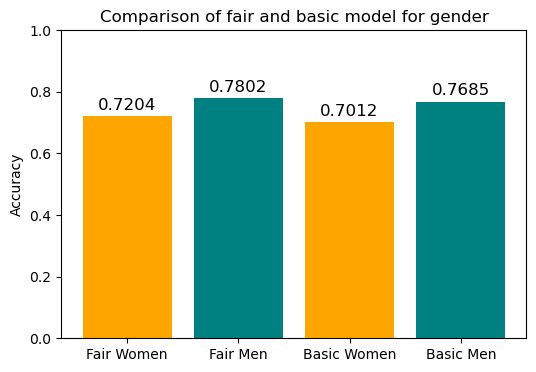

In [202]:

# Accuracy values
genders = ["Fair Women", "Fair Men", "Basic Women", "Basic Men"]
accuracies_g = [fair_women, fair_men, basic_women, basic_men]

# Plot the accuracies
plt.figure(figsize=(6, 4))
plt.bar(genders, accuracies_g, color=['orange', 'teal'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Comparison of fair and basic model for gender")
plt.xticks(rotation=0)

# Display values on bars
for i, acc in enumerate(accuracies_g):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha='center', fontsize=12)

plt.show()

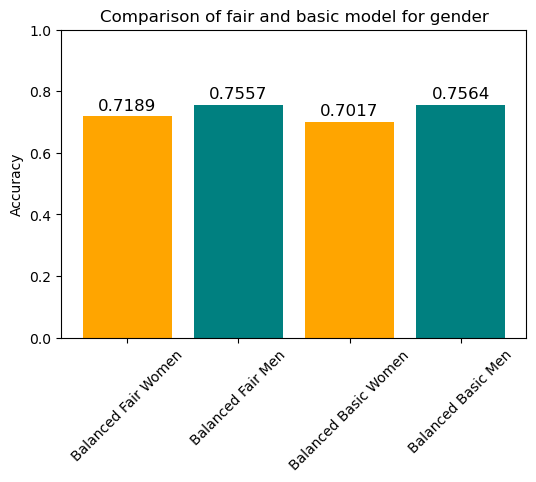

In [216]:

# Accuracy values
balanced_genders = ["Balanced Fair Women", "Balanced Fair Men", "Balanced Basic Women", "Balanced Basic Men"]
balanced_accuracies_g = [balanced_fair_women, balanced_fair_men, balanced_basic_women, balanced_basic_men]

# Plot the accuracies
plt.figure(figsize=(6, 4))
plt.bar(balanced_genders, balanced_accuracies_g, color=['orange', 'teal'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Comparison of fair and basic model for gender")
plt.xticks(rotation=45)

# Display values on bars
for i, acc in enumerate(balanced_accuracies_g):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha='center', fontsize=12)

plt.show()

Now for race

In [169]:
# Compute cost with random beta-values and parameters
np.random.seed(42)
compute_cost(
    beta = np.random.rand(X_train_small.shape[1]),
    X = X_train_small, 
    y = y_train_small,
    groups = group_r_train_small, 
    group_type = "race",
    _gamma = 1, 
    _lambda = 0.1
)


5.401961818984595

In [170]:
# Set seed and define params
np.random.seed(23)
beta = np.random.rand(X_train_small.shape[1])
lambda_ = 0.1
gamma_ = 1e-5 

# Run optimization
result_r, _, _ = opt.fmin_tnc(
    func=compute_cost,
    x0=beta,
    fprime=compute_gradients,
    approx_grad=False,
    maxfun = 500,
    args = (
        X_train_small, 
        y_train_small,
        group_r_train_small,
        "race",
        lambda_, 
        gamma_
    ),
    xtol=1e-7,
    ftol=1e-5
)

  NIT   NF   F                       GTG
    0    1  1.915777665845811E+00   1.31349986E+00
    1    6  6.492695811805719E-01   1.86866633E-01
    2    9  4.481697210743187E-01   2.07726994E-03
    3   15  4.251450019410666E-01   1.43482772E-04
tnc: fscale = 56.4887
    4   24  4.199559719172797E-01   2.20589081E-05
    5   32  4.183605526436989E-01   1.66689302E-06
    6   35  4.182444107173471E-01   3.90257196E-06
    7   40  4.181750589813221E-01   8.34182363E-08
tnc: fscale = 2094.73
tnc: |fn-fn-1] = 1.88574e-06 -> convergence
    8   44  4.181731732378561E-01   2.57291445E-08
tnc: Converged (|f_n-f_(n-1)| ~= 0)


In [173]:

# Save result
np.save("optimized_beta_r_10000.npy", result_r)



In [174]:
# Load result next time
result_r = np.load("optimized_beta_r_10000.npy")

In [175]:
from sklearn.metrics import accuracy_score

y_pred_fair_r = np.array([True if x >=0.5 else False for x in sigmoid(result_r @ X_test_small.T)])

accuracy_score(y_test_small, y_pred_fair_r)

0.7361

In [176]:
logistic_model = LogisticRegression(max_iter=5000, penalty="l2", C=0.8497534359086438, tol=1e-4, solver="saga")
logistic_model.fit(X_train_small, y_train_small)
log_y_pred = logistic_model.predict(X_test_small)
accuracy = accuracy_score(y_test_small, log_y_pred)
accuracy
#f1_score = f1_score(y_test_small, log_y_pred) 
balanced_accuracy = balanced_accuracy_score(y_test_small, log_y_pred)

In [191]:
accuracy
balanced_accuracy

0.7324511504512965

In [178]:
print('Fair')
print(f'Group 0: {accuracy_score(y_test_small[group_r_test_small==0], y_pred_fair_r[group_r_test_small==0]):.3f}\nGroup 1: {accuracy_score(y_test_small[group_r_test_small==1], y_pred_fair_r[group_r_test_small==1]):.3f}\n')
print('Basic')
print(f'Group 0: {accuracy_score(y_test_small[group_r_test_small==0], log_y_pred[group_r_test_small==0]):.3f}\nGroup 1: {accuracy_score(y_test_small[group_r_test_small==1], log_y_pred[group_r_test_small==1]):.3f}')

Fair
Group 0: 0.740
Group 1: 0.734

Basic
Group 0: 0.739
Group 1: 0.734


In [194]:
print('Fair')
print(f'Group 0: {balanced_accuracy_score(y_test_small[group_r_test_small==0], y_pred_fair_r[group_r_test_small==0]):.3f}\nGroup 1: {balanced_accuracy_score(y_test_small[group_r_test_small==1], y_pred_fair_r[group_r_test_small==1]):.3f}\n')
print('Basic')
print(f'Group 0: {balanced_accuracy_score(y_test_small[group_r_test_small==0], log_y_pred[group_r_test_small==0]):.3f}\nGroup 1: {balanced_accuracy_score(y_test_small[group_r_test_small==1], log_y_pred[group_r_test_small==1]):.3f}')

Fair
Group 0: 0.736
Group 1: 0.730

Basic
Group 0: 0.735
Group 1: 0.731


In [192]:
fair_white = accuracy_score(y_test_small[group_r_test_small==1], y_pred_fair_r[group_r_test_small==1])
fair_non_white = accuracy_score(y_test_small[group_r_test_small==0], y_pred_fair_r[group_r_test_small==0])

basic_white = accuracy_score(y_test_small[group_r_test_small==1], log_y_pred[group_r_test_small==1])
basic_non_white = accuracy_score(y_test_small[group_r_test_small==0], log_y_pred[group_r_test_small==0])

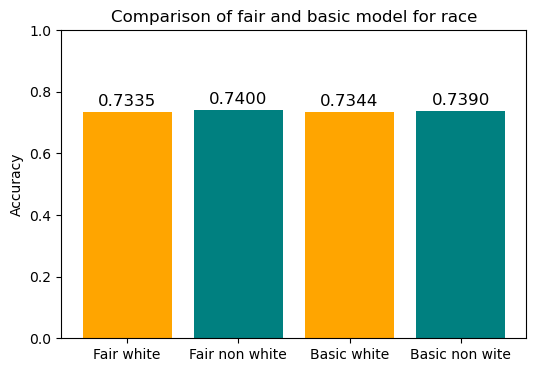

In [211]:

# Accuracy values
races = ["Fair white", "Fair non white", "Basic white", "Basic non wite",]
accuracies_r = [fair_white, fair_non_white, basic_white, basic_non_white]

# Plot the accuracies
plt.figure(figsize=(6, 4))
plt.bar(races, accuracies_r, color=['orange', 'teal'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Comparison of fair and basic model for race")
plt.xticks(rotation=0)

# Display values on bars
for i, acc in enumerate(accuracies_r):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha='center', fontsize=12)

plt.show()

balanced accuracy plots

In [203]:
balanced_fair_white = balanced_accuracy_score(y_test_small[group_r_test_small==1], y_pred_fair_r[group_r_test_small==1])
balanced_fair_non_white = balanced_accuracy_score(y_test_small[group_r_test_small==0], y_pred_fair_r[group_r_test_small==0])

balanced_basic_white = balanced_accuracy_score(y_test_small[group_r_test_small==1], log_y_pred[group_r_test_small==1])
balanced_basic_non_white = balanced_accuracy_score(y_test_small[group_r_test_small==0], log_y_pred[group_r_test_small==0])

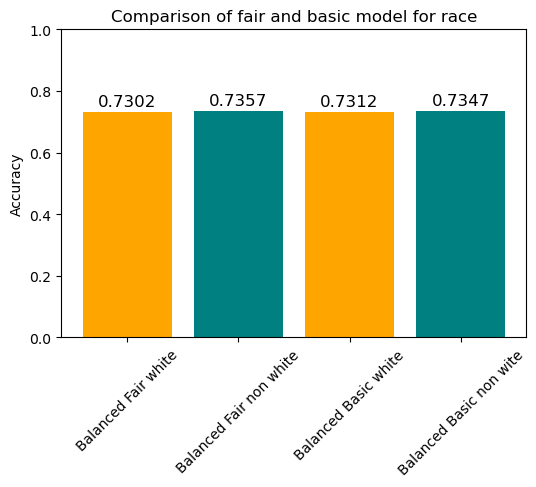

In [206]:

# Accuracy values
balanced_races = ["Balanced Fair white", "Balanced Fair non white", "Balanced Basic white", "Balanced Basic non wite"]
balanced_accuracies_r = [balanced_fair_white, balanced_fair_non_white, balanced_basic_white, balanced_basic_non_white]

# Plot the accuracies
plt.figure(figsize=(6, 4))
plt.bar(balanced_races, balanced_accuracies_r, color=['orange', 'teal'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Comparison of fair and basic model for race")
plt.xticks(rotation=45)

# Display values on bars
for i, acc in enumerate(balanced_accuracies_r):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha='center', fontsize=12)

plt.show()